<a href="https://colab.research.google.com/gist/parulnith/7f8c174e6ac099e86f0495d3d9a4c01e/untitled9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM min timeseries based Progressive Rock and Others genres music classification

Use time series sample for all the features. Since different songs have different length we find the least number of samples present among all songs and take that many samples for each song.

## Importing Libraries.

In [0]:
# feature extractoring and preprocessing data
import librosa
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import load_model
from keras import models
from keras import layers
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional

from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import confusion_matrix
from keras.layers.advanced_activations import ELU
#Keras
import keras

import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## User Parameters
**hop_length**: number of audio samples between successive frames  
**folders**: Name of the folders in path which contains differnet genres of songs.   
**songsPath**: Folder location where all the songs are present  
**savePath**: Folder location where generated feature will be saved  
**XFeatureFileName**: File name for the generated Input features for training  
**YFeatureFileName**: File name for the Labels corresponding to inputs for training  
**X_ValidationFeatureName**:  File name for the generated Input features from validation set  
**Y_ValidationFeatureName**:  File name for the Labels corresponding to input features from validation set  
**modelName**:  File name to save the trained model  


In [0]:

hop_length = 512
folders = 'Progressive Rock Songs;Other Songs;Additional Pop Songs;Top Of The Pops'.split(';')
songsPath = f'/content/gdrive/My Drive/ML test/'
savePath = f'/content/gdrive/My Drive/My test/'
XFeatureFileName = "X_LSTM_minTimeSeries_Train.npy"
YFeatureFileName = "Y_LSTM_minTimeSeries_Train.npy"
X_ValidationFeatureName = 'X_LSTM_minTimeSeries_Validation.npy'
Y_ValidationFeatureName = 'X_LSTM_minTimeSeries_Validation.npy'
modelName = 'LSTM_min_time_series_model.h5'

## Extract Features

We will extract

* Mel-frequency cepstral coefficients (MFCC)(20 in number)
* Spectral Centroid,
* Zero Crossing Rate
* Chroma Frequencies
* Spectral Roll-off.

The generated input feature is a 3-D matrix of number_of_song X number_of_time_sample_for_each_song  X 13

Extracted features are saved to location provided by user

In [0]:

list_of_audiofiles = []
label = []
timeseries_length_list = []
for g in folders:
  for filename in os.listdir(songsPath + g):
    songname = songsPath + g + '/' + filename
    list_of_audiofiles.append(songname)
    folderName = g.replace(" ","")
    if(folderName != "ProgressiveRockSongs"):
      label.append(0)  # Non Prog Rock
    else:
      label.append(1)  # Prog Rock
      
for file in list_of_audiofiles:
  y, sr = librosa.load(file)
  timeseries_length_list.append(math.ceil(len(y) / hop_length))
  print(min(timeseries_length_list))

timeseries_length = min(timeseries_length_list)
print(timeseries_length)
print("Done")

In [0]:

def extract_audio_features():
#         timeseries_length = 1590
        data = np.zeros((len(list_of_audiofiles), timeseries_length, 41), dtype=np.float64)
        target = []
        count = 0 
        for i, file in enumerate(list_of_audiofiles):
            y, sr = librosa.load(file)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13)
            spectral_center = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length)
            chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length)
            spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=hop_length)
            rmse = librosa.feature.rmse(y=y,hop_length=hop_length)
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr, hop_length=hop_length)
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, hop_length=hop_length)
            zcr = librosa.feature.zero_crossing_rate(y=y, hop_length=hop_length)
            spec_flatness = librosa.feature.spectral_flatness(y=y, hop_length=hop_length)
            rms_feat = librosa.feature.rms(y=y, hop_length=hop_length)
            poly_feat = librosa.feature.poly_features(y=y, sr=sr, hop_length=hop_length)
            tonnetz_feat = librosa.feature.tonnetz(y=y, sr=sr)
            target.append(label[i])

            data[i, :, 0:13] = mfcc.T[0:timeseries_length, :]
            data[i, :, 13:14] = spectral_center.T[0:timeseries_length, :]
            data[i, :, 14:26] = chroma.T[0:timeseries_length, :]
            data[i, :, 26:33] = spectral_contrast.T[0:timeseries_length, :]
            data[i, :, 33] = rmse.T[0:timeseries_length, 0]
            data[i, :, 34] = spec_bw.T[0:timeseries_length, 0]
            data[i, :, 35] = rolloff.T[0:timeseries_length, 0]
            data[i, :, 36] = zcr.T[0:timeseries_length, 0]
            data[i, :, 37] = spec_flatness.T[0:timeseries_length, 0]
            data[i, :, 38] = rms_feat.T[0:timeseries_length, 0]
            data[i, :, 39] = poly_feat.T[0:timeseries_length, 0]
            data[i, :, 40] = tonnetz_feat.T[0:timeseries_length, 0]
            count +=1;

        return data, np.expand_dims(np.asarray(target), axis=1)
X,Y = extract_audio_features()
# Uncomment below lines of code to save feature set.
# with open(savePath + XFeatureFileName, 'wb') as f:
#   np.save(f, X)
# with open(savePath + YFeatureFileName, 'wb') as f:
#   np.save(f, Y)

## Train Model

In [0]:
 X = np.load(savePath + XFeatureFileName)
 Y = np.load(savePath + YFeatureFileName)

#### Ucomment below lines of code to Train on equal no of prog and non prog and just on mfcc feature.

In [0]:

# X = X[0:150,:,0:13]
# print(X.shape)
# Y = Y[0:150][:]
# print(Y.shape)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

Compiling ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 1590, 128)         87040     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 128,321
Trainable params: 128,321
Non-trainable params: 0
_________________________________________________________________
Train on 300 samples, validate on 75 samples
Epoch 1/5
300/300 [==============================] - 49s 164ms/step - loss: 0.5794 - acc: 0.7933 - val_loss: 0.4935 - val_acc: 0.8133
Epoch 2/5
300/300 [==============================] - 43s 143ms/step - loss: 0.5059 - acc: 0.8000 - val_loss: 0.4979 - val_acc: 0.8133
Epoch 3/5
300/300 [==============================] - 43s 143ms/step - los

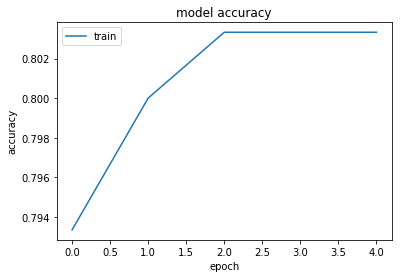

In [0]:
model = models.Sequential()

model.add(LSTM(units=128, dropout=0.05, recurrent_dropout=0.35, return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2]))) 
model.add(Bidirectional(LSTM(units=32, dropout=0.05, recurrent_dropout=0.35, return_sequences=False)))
model.add(layers.Dense(units=1, activation='sigmoid'))


print("Compiling ...")
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()


history = model.fit(X_train,y_train,  validation_data=(X_test, y_test), epochs = 5, batch_size=64)

model.save(savePath + modelName)

plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
                   

In [0]:
test_loss, test_acc = model.evaluate(X_test,y_test)
print('test_acc: ',test_acc)

75/75 [==============================] - 3s 37ms/step
test_acc:  0.8133333373069763


In [0]:
predictions = model.predict(X_test)
print(predictions.shape, X_test.shape)
error = 0
y_pred = np.ones(y_test.shape)
for i in range(predictions.shape[0]):
    if(predictions[i] > 0.5):
      out = 1
    else:
      out = 0
    y_pred[i] = out
    if(out != y_test[i][0]):
      error +=1
confusion_matrix(y_test,y_pred)

(75, 1) (75, 1590, 41)


array([[61,  0],
       [14,  0]])

## Test Model on Validation Set

In [0]:
model = load_model(savePath + modelName)

X_val = np.load(savePath + X_ValidationFeatureName)
y_val = np.load(savePath + Y_ValidationFeatureName)
print(X_val.shape,y_val.shape)
X_val = X_val[:,0:1590,0:41]
predictions = model.predict(X_val)
print(predictions.shape, X_val.shape)
error = 0
y_pred = np.ones(y_val.shape)
for i in range(predictions.shape[0]):
    if(predictions[i] > 0.5):
      out = 1
    else:
      out = 0
    y_pred[i] = out
    if(out != y_val[i][0]):
      error +=1
confusion_matrix(y_val,y_pred)

(92, 5170, 42) (92, 1)
(92, 1) (92, 1590, 41)


array([[71,  0],
       [21,  0]])